# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

# Question 1: Reading

**1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).**

#### Idea:

The paper presents a system that can match and reconstruct 3D scenes from extensive collections of photographs found by searching for a given city (e.g., Rome) on the Internet. Their system uses an array of novel parallel distributed matching and reconstruction algorithms designed to maximize parallelism at each stage in the pipeline and minimize serialization bottlenecks. Using this reconstruction, a city could be 'built' using considerable resources and data in a day or less. Another primary purpose was to scale the system appropriately based on the possible computational ability and the extent of the given problem. This system is one to two orders of magnitude larger than the most extensive results reported in the literature. The system has used the existing matching algorithms and SfM algorithms such as SIFT, bundle adjustment, etc.


#### Challenges:
Some of the difficulties encountered are:

1. Structured data collected from the same calibrated camera at a constant sampling rate and different sensors, make the calculations more flexible. On the other hand, unstructured data is taken from different cameras, in changing lighting conditions, with significantly less geographic data and no camera calibration knowledge. As only unstructured information is available online, the primary problem is this. 
    
2. The step in the pipeline involving pruning and verifyng matches using a RANSAC-based estimation of essential or fundamental matrix is computationally very heavy; we cannot implement this on all the image features and therefore need to be filtered before applying this process.
    
3. It was essential to choose good algorithms that would satisfy the requirement of optimized memory usage and I/O bandwidth while choosing algorithms that work well together, scale well and provide high performance. In some cases, the authors designed and implemented the algorithms themselves.
4. Metadata such as the website and username are used to group images, which may or may not always be practical. A better strategy would exploit all the textual tags and geotags associated with the images to predict what images are likely to match and then distribute the data accordingly.
5. Since multi-threading and parallelism are not implemented in all parts and rely on the redundancy in various images, scaling is a problem. More optimization is required in the way pictures are distributed for processing.
6. The current system uses batch jobs. However, adding more images to extend the system could be more effective.
7. The track generation process merges tracks based on shared features, and inconsistent tracks can be generated. In such cases, they drop the offending points from the track.
8. We use the skeletal sets algorithm to find this minimal set, which computes a spanning collection of photographs that preserve important connectivity data in the image graph. A two-frame reconstruction is calculated for each matching image pair with known focal lengths.


#### Implementing the pipeline:

The essential steps include pre-processing, image-matching, track-generation, geometric estimation, and distributed Computing Engine.
1. In pre-processing, the images are assigned to cluster nodes from a central store. This is done in order to download images without being affected by the experiments on-demand in fixed-size chunks to perform load balancing. After verifying the is done, we extract the EXIF tags and record the focal length. Next, larger images are downsampled with maintaining aspect ratios and scaling focal lengths. The subsequent steps include converting to grayscale, extracting SIFT features, and partitioning the images.
2. For matching, a multi-stage matching scheme was used. Each stage involved a proposal and a verification step. The system determines a set of image pairs that share general scene elements, and the confirmation involves specific and extensive feature matching. Next, vocabulary trees and query expansion are used for proposals and a greedy bin-packing algorithm to choose images to transfer to each node for verification involving photometric matching between feature descriptors and determining the essential or fundamental matrix depending on the available information.
3. For each connected component the run structure is generated after track generation. It is good to reconstruct a minimal subset of images capturing essential connectivity of scene geometry and match graph. Pose estimation and a final bundle adjustment for refining SFM estimates could be used for adding all the remaining images. A skeletal sets algorithm is used by the authors that computes the spanning set of images. This set is used for estimating SFM parameters of the resulting components. The algorithm yields a larger set of components.

The main stages of the pipeline can be concluded to have initially a pre-processing, matching, and geometric estimation. The pipeline involves dividing N images on M processors. Next, SIFT is used for feature extraction, and vocabulary tree vector quantization and term frequency counting are performed further. Subsequently, document frequency counting, TFIDF computation, and information broadcast are completed. The match verification tasks are then distributed using a round-robin bin-packing. Eventually, the match verification and proposal expansion occur depending on the images found in connected components using the next best k2 matches per image. Later, additional distributed verification, four more rounds of query expansion and validation, and track merging from local verified matches, followed by track aggregation into C connected components. Image-related components and distributed merging finally distribute the tracks.





**2. How is this task different from a SLAM problem?**

SLAM or Simultaneous localization and mapping is the computational problem of constructing or updating a map of an unknown environment while simultaneously keeping track of an agent's location within it. Here, images are obtained and used for constructing or updating the map of an unknown environment. In the SLAM problem, the poses of the robot are optimized using the given odometric constraints. Map of the unknown environment is constructed/updated while simultaneously keeping track of the agent's location within the map. Visual simultaneous localization and mapping (vSLAM) is the process of calculating the position and orientation of a camera, with respect to its surroundings, while simultaneously mapping the environment. This is different from the problem described in the  paper because the paper does not involve any sort of localization.It revolves around finding and matching various images and reconstructing a 3D environment. The paper doesn't involve any "real-time" images from a moving robot to create the map unlike in SLAM. The paper deals with images and data collected from the internet to connect isolated components together and recreate various sections of the environment by assembling all the pieces of information together.

# Question 2: Code!

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from http://grail.cs.washington.edu/projects/bal/ for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [2]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d

INFO - 2021-12-03 21:55:48,053 - utils - NumExpr defaulting to 8 threads.


First download the data file:

In [28]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "venice/"
FILE_NAME = "problem-89-110973-pre.txt.bz2"

URL = BASE_URL + DATASET_NAME + FILE_NAME

In [29]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [30]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [31]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [32]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (89, 9);
points_3d: (110973, 3);
camera_indices: (562976,); 
point_indices: (562976,); 
points_2d: (562976, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

# Visualise Point Cloud

Visualise `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [33]:
pcd_cloud = o3d.geometry.PointCloud()
pcd_cloud.points = o3d.utility.Vector3dVector(points_3d[:100000,:100000])
o3d.visualization.draw_geometries([pcd_cloud])


![pcd_2.png](./pcd_2.png)

# Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [34]:
n_cameras = camera_params.shape[0]
# points_3d = points_3d[:100000,:100000]
# point_indices = point_indices[:100000]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 89
n_points: 110973
Total number of parameters to estimate: 333720
Total number of residuals: 1125952


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [35]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
![radial_distortion_1.png](./misc/radial_distortion_1.png) 
![radial_distortion_2.png](./misc/radial_distortion_2.png)

In [36]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    proj_points = rotate(points, camera_params[:, :3])
    proj_points += camera_params[:, 3:6]
    proj_points = -proj_points[:, :2] / proj_points[:, 2, np.newaxis]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(proj_points ** 2, axis=1)
    r = 1 + k1*n + k2*n*n
    f = camera_params[:, 6]
    proj_points = proj_points * (r * f)[:, np.newaxis]
    return proj_points

In [37]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](../misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](../misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of datastructures that are meant for such a usecase - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [38]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [39]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
            
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A

### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

In [41]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [42]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

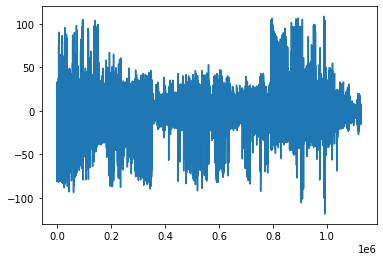

In [43]:
plt.plot(f0)

In [44]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

(1125952, 333720) 89 110973


### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

In [45]:
import time
from scipy.optimize import least_squares

In [46]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8752e+07                                    3.32e+07    
       1              3         1.4669e+07      4.08e+06       2.18e+01       1.18e+08    
       2              5         1.4449e+07      2.20e+05       5.90e+00       1.28e+08    
       3              6         1.4446e+07      3.31e+03       1.39e+00       1.31e+08    
       4             12         1.4446e+07      0.00e+00       0.00e+00       1.31e+08    
`xtol` termination condition is satisfied.
Function evaluations 12, initial cost 1.8752e+07, final cost 1.4446e+07, first-order optimality 1.31e+08.


In [47]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [48]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
o3d.visualization.draw_geometries([pcd])

![pcd_2.png](./pcd_2.png)
Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [49]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 35 seconds


Now let's plot residuals at the found solution:

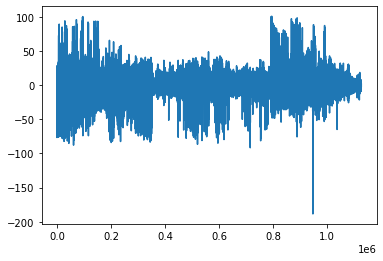

In [50]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Theory

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics:
        When a camera takes a picture, it often stores the timestamp of the image. based on these timestamps, we can assign `camera_ind` to each of the images by iteratinfg over them. 
        The backend structure of the motion pipeline contains Bundle adjustment. The working of the frontend part can be demonstrated through the following steps -
        - From various unknown locations, multiple images of the same object are captured with (usually) the same camera.
        - SIFT / ORB is applied on the first 2 consecutive images to obtain common feature points in these images. 
        - Essential matrix and Fundamental matrix are obtained using 8 point algorithm. These matrices are then decomposed into rotation matrix(R) and translation matrix(T) between the 2 images.
        - Using the same scale during the whole process, we triangulate from image points to 3D world.
        - The information about the source of the points being back-projected is stored in camera_ind. And this information is known to us.
        - PnP is applied over the correspondences between the third image and the reconstructed world to obtain the rotation matrix and translation matrix of the third image on the same scale.
        - This process is repeated for all the images.
        Thus, the correspondence between the points_2d and the camera to which these points belong are known since these points are chosen after applying SIFT/ORB or some other feature detection algorithm on the image from that camera.

    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: 
        - In the frontend pipeline, once the F, E, R and t matrices are estimated, the initial estimates of the 3D points are generated by triangulating and back-projecting 2D points from the images. 
        - So, because of the nature of the method used, we can easily find out the correspondence between the 3D points and the 2D points from which they were generated. For representing the correspondence, we can use indices for each of the 2D points and label the corresponding 3D points with the same index.

3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: 
    If v is a vector in ℝ3 and k is a unit vector describing an axis of rotation about which v rotates by an angle θ according to the right hand rule, the Rodrigues formula for the rotated vector $v_{rot}$ is
$$
 {\mathbf {v} _{\mathrm {rot} }=\mathbf {v} \cos \theta +(\mathbf {k} \times \mathbf {v} )\sin \theta +\mathbf {k} ~(\mathbf {k} \cdot \mathbf {v} )(1-\cos \theta )}
$$
Using axis angle for rotation instead of rotation matrix, number of parameters that we need to estimate get reduced. The total number of parameters is just 3. By extension, this formula can be used to transform all three basis vectors to compute a rotation matrix in SO(3), the group of all rotation matrices, from an axis–angle representation.

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: 
        - `M` denotes the number of images and `N` denotes the number of points in each image. So the total number of points is `2MN` but for this case, the number of points are not constant for every image. Therefore this is not a function of `MN`.
        - The estimated camera intrinsics and extrinsics are used in the project function for projecting 3D points into 2D image planes. 
        - It is necessary to transform 3D points in an arbitrary world frame to the camera’s local frame since every camera is at a different position.
        - The point is first rotated from world frame to local camera frame to correct for rotation and then origin offset is corrected within this camera frame.
        $$
            \mathbf{{}^{c}p} = R^{c}_{w}\mathbf{{}^{w}p} + \mathbf{{}^{c}t^{c}_{w}}
         $$
            The left superscript is the frame that contains the representation of the vector.

        - The vector representations lying in different planes can not be directly added. Thus, point $\mathbf{{}^{w}p}$ must be first rotated into the camera from before adding to $\mathbf{{}^{c}t^{c}_{w}}$  since $\mathbf{{}^{c}t^{c}_{w}}$ itself lies in the camera frame. So rotation can not be applied after translation.
        - The equation of transformation if the translation was defined in the world frame -
$$
    \mathbf{{}^{c}p} = R^{c}_{w}\left(\mathbf{{}^{w}p} + \mathbf{{}^{w}t^{c}_{w}}\right) = R^{c}_{w}\mathbf{{}^{w}p} + R^{c}_{w}\mathbf{{}^{w}t^{c}_{w}}
 $$

        - The equation is difficult to optimize since it couples together the rotation and translation matrix. Otherwise, the product of R and t needs to be treated as a separate parameter. And thus we need to go back to the previous formulation as $R^{c}_{w}\mathbf{{}^{w}t^{c}_{w}}$ is simply $\mathbf{{}^{c}t^{c}_{w}}$)
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian:
        - The number of rows in a Jacobian matrix equals the number of residuals since each row corresponds to a residual. 
        - This is equal to the number of 2D points since the loss function computes the difference between the reprojected 2D points computed based on the estimated camera parameters and estimated 3D points and observed 2D points obtained from the images. 
        - As every 2D point contributes to an x and a y coordinate, the number of residuals is twice the number of 2D points. There are camera_indices.size number of 2D points as every element in camera_indices relates a 2D point to an image and so we have twice as many residuals in the Jacobian.

6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: 
        - The camera parameters and 3D world point positions are optimised using Bundle adjustment.
        - Thus the number of parameters that we optimise over is - *Number of camera parameters* $\times$ *Number of cameras* $+$ *Number of coordinates* $\times$ *Number of world points*
         - In lecture notes we considered a 3 X 4 matrix that represents the camera projection matrix, then $P = K \left[R | t \right]$ matrix gives us 12 parameters for each camera. Since a 3 X 3 matrix was used to represent camera intrinsics and rotation matrices were also represented as 3 X 3 matrices.
        - But here the number of camera parameters we have is 
            - 3 parameters representing axis-angle rotation
            - 3 parameters representing a translation
            - Focal length
            - 2 distortion parameters
            Thus, there is a total of 9 parameters.
        - When we go from rotation matrices to axis-angles and camera intrinsic matrix to individual intrinsic properties, the number of parameters reduces from 12 to 9. 

    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters:        
            - Bundle adjustment optimizes the estimates of 3D world points (generated by structure from Motion frontend) and camera positions.
            - Since we know the camera intrinsics, it can be concluded that the parameters we aim to optimise are 6 degrees of freedom per camera, that is 3 rotations and 3 translations and 3 degrees of freedom for every world point, that is its ($x$, $y$ and $z$) coordinates.
            - Thus the total number of parameters to be estimated is -6 * `n_cameras` + 3 * `n_points`
            - But the optimisation will have to be performed in SO(3) manifold instead of Euclidean space. For avoiding this situation, we can optimise the projection matrix as it is, essentially optimises the extrinsic and intrinsic parameters $P = K \left[R | t \right]$
            - So the number of unknown parameters is  12 * `n_cameras` + 3 * `n_points`
            - In this case, the intrinsic and extrinsic parameters are optimised separately. This is possible as rotation is represented using axis-angles.
            - The number of parameters is 3 for translation, 3 for rotation (axis-angles) and 3 intrinsic parameters (for this case, otherwise there may be 5 intrinsic parameters). This gives us 9 parameters for each camera and a total of  9 * `n_cameras` + 3 * `n_points` parameters.
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 7 - Sparsity, Residual Vector & Jacobian: 
**Structure of the Jacobian matrix** -
- Each row corresponds to a residual.
- Each column corresponds to a parameter to be optimised. The total number of columns is  9 * `n_cameras` + 3 * Number of world point parameters (since that is the number of parameters to be optimised)
- There are 2 equations corresponding to each 2D point, one for its x coordinate and one for the y coordinate. Thus the number of residuals is twice the number of observations and so is the number of rows.
- In the lecture notes, it was considered that N world points are visible in all M images, then we have 2MN rows. 
- The number of observations is `camera_ind.size` and we have twice as many rows.
- The residuals may not appear in a particular order unlike the residuals considered in the lecture notes which were initially ordered according to points and then according to images. Random ordering works as long as a single ordering is maintained consistently.

**The function of the code snippet** -
- The elements of the Jacobian which are not always zero are marked using the code snippet. Thus `SciPy` solver can take advantage of the Jacobian matrix’s sparsity. 
- All the columns corresponding to the parameters of a camera are set to 1 using `Numpy`’s array indexing. 
- All the remaining elements are zero since those represent the cameras and world points not included in the observation. These zero elements contribute to the sparse structure of the matrix.
- In the below code, in the theoretical setting, we define the structure of the Jacobian. However, in the practical setting, based on the dependant variables which are to be optimized (like, the 3D points and the camera parameters) we decide whether to set the value at an index to 1. Thus, the matrix will not be as structured as in the previous case. Also, the run time of the code will decrease due to the sparsity of the Jacobian matrix.

In [4]:
camera_ind_exp = 10
m = camera_ind_exp * 2
B = np.zeros([m,16])
B_prac = np.zeros([m,16])
i = np.arange(camera_ind_exp)

# theoretical setting
B[2*i, np.array([0,0,0,0,0,  1,1,1,1,1])]=1
B[2*i + 1, np.array([0,0,0,0,0,  1,1,1,1,1])]=1
# practical setting
B_prac[2*i, np.array([0,2,5,6,2,  1,9,14,7,11])]=1
B_prac[2*i + 1, np.array([0,2,5,6,2,  1,9,14,7,11])]=1

print("The theoretical sparse matrix")
print(B)
print("The practical sparse jacobian")
print(B_prac)

The theoretical sparse matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

1. First, we do feature matching using the following function calls:
   ```python
   sift = cv2.SIFT_create() # optional parameter nfeatures (number of features required)
   keypoints1, descriptors1 = sift.detectAndCompute(img1, None) # None parameter is to specify no additional parameters
   keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
   ```
   `detectAndCompute()` returns the keypoints and their corresponding descriptors for the two input images. SURF or ORB features can also be used instead of SIFT. The corresponding features between the two images is then matched using K-Nearest-Neighbour based matching.
   ```python
   matcher = cv2.FlannBasedMatcher({'algorithm'=1, 'trees'=5}, {'checks'=32}) # algorithm 1 refers to KD-Tree
   # initializing the kNN-based matcher with descriptors of the two images and k value
   matches = matcher.knnMatch(descriptors1, descriptors2, k=2) # match the descriptors
   ```
   Points in the first image (`pts1`) and points in the second image (`pts2`)  are obtained by separating the matching points from `matches` as follows:
   ```python
   pts1 = np.array([keypoints1[match[0].queryIdx].pt for match in matches])
   pts2 = np.array([keypoints2[match[0].trainIdx].pt for match in matches])
   ```
   To improve the quality of the matches, Lowe's Test can be used. For this, each keypoint of the first image is matched with a number of keypoints from the second image. The 2 best matches for each keypoint are kept (best matches are the ones with the smallest distance measurement). Lowe's test checks that the two distances are sufficiently different. If they are not, then the keypoint is discarded.
<br/>
2. We can find the essential matrix using `cv2.findEssentialMatrix`. The parameters to this function are the lists of matching points (`pts1` and `pts2`) and the camera intrinsics, calibration matrix `K`. The `method` parameter can be set to `cv2.RANSAC`, and RANSAC's threshold and probability values can be manipulated accordingly.  
<br/>
3. Now we can decompose the essential matrix into R,t as follows:

    `Rt = cv2.recoverPose(E, pts1, pts2, K)`: This takes the Essential matrix E, the corresponding points in 2 images and the camera intrinsics matrix K as input parameters and returns R and t. `Rt[1]` gives us R and `Rt[2]` gives us t.  
<br/>
4. Using the camera extrinsics, R and t, we can find the 3D points as follows:  
   ```python
   P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1)))) # first camera's extrinsic matrix is [I | 0]
   P2 = K @ np.hstack((R, t)) # second camera's extrinsic matrix is [R | t]
   ptsW = cv2.triangulatePoints(P1, P2, pts1, pts2) # triangulate back the points
   ptsW /= ptsW[3] # homogenize
   ptsW[:3] # world points
   ```
   The above calculation was done considering the first camera's frame. Therefore the obtained points are in 1st camera's frame.